<a href="https://colab.research.google.com/github/nomotoT/Python_Lesson/blob/master/%E3%83%A1%E3%83%87%E3%82%A3%E3%82%AB%E3%83%ABAI%E7%AC%AC8%E7%AB%A0%E5%BF%83%E9%9B%BB%E5%9B%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. 実践編: ディープラーニングを使ったモニタリングデータの時系列解析


In [2]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==2.4.1
astor==0.7.1
astropy==3.0.5
atari-py==0.1.7
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.6
autograd==1.2
Babel==2.6.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
bokeh==1.0.4
boto==2.49.0
boto3==1.9.123
botocore==1.12.123
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.0
certifi==2019.3.9
cffi==1.12.2
chainer==5.0.0
chainercv==0.12.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cupy-cuda100==5.2.0
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.6
cytoolz==0.9.0.1
daft==0.0.4
dask==0.20.2
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
distributed==1.25.3
Django==2.1.7
dlib==19.16.0
dm-sonnet==1.23
docopt==0.6.2
docutils==0.14

In [3]:
!apt -y -q install tree
!pip install wfdb==2.2.1 imbalanced-learn==0.4.3

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (122 kB/s)
Selecting previously unselected package tree.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
    100% |████████████████████████████████| 102kB 3.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641

In [4]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5724      0 --:--:-- --:--:-- --:--:--  5724
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [5]:
import os
import random
import numpy as np
import chainer
import scipy
import pandas as pd
import matplotlib
import seaborn as sn
import wfdb
import sklearn
import imblearn

chainer.print_runtime_info()
print("Scipy: ", scipy.__version__)
print("Pandas: ", pd.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Seaborn: ", sn.__version__)
print("WFDB: ", wfdb.__version__)
print("Scikit-learn: ", sklearn.__version__)
print("Imbalanced-learn: ", imblearn.__version__)

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.2.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3
Scipy:  1.1.0
Pandas:  0.22.0
Matplotlib:  3.0.3
Seaborn:  0.7.1
WFDB:  2.2.1
Scikit-learn:  0.20.3
Imbalanced-learn:  0.4.3


In [0]:
# 乱数シード固定

def reset_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(42)

8.2. 心電図(ECG)と不整脈診断について

標準的な心電図は，手足からとる心電図（四肢誘導）として，双極誘導（Ⅰ，Ⅱ，Ⅲ），及び単極誘導（aVR，aVL，aVF）の6誘導，胸部からとる心電図（胸部誘導）として，V1，V2，V3，V4，V5，V6の6誘導，計12誘導から成ります．このうち，特に不整脈のスクリーニングを行う際には，Ⅱ誘導とV1誘導に注目して診断が行われるのが一般的とされています．

心臓が正常な状態では，ECGにおいては規則的な波形が観測され，これを正常洞調律 (Normal sinus rhythm, NSR)といいます．

具体的には，以下の3つの主要な波形で構成されており，

P波：心房の脱分極（心房の興奮）

QRS波：心室の脱分極（心室の興奮）

T波：心室の再分極（心室興奮の収まり）

In [0]:
# 8.3. 使用するデータセット
# 47名の患者から収集した48レコードが登録されており，各レコードファイルには約30分間の2誘導(II，V1)のシグナルデータが格納されています．
# また，各R波のピーク位置に対してアノテーションが付与されています．

dataset_root = './dataset'
download_dir = os.path.join(dataset_root, 'download')


In [17]:
  wfdb.dl_database('mitdb/', dl_dir=download_dir)
 # wget -r -np http://physionet.org/physiobank/database/mitdb/


Created local base download directory: ./dataset/download
Finished downloading files


In [18]:
print(sorted(os.listdir(download_dir)))

['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea', '103.atr', '103.dat', '103.hea', '104.atr', '104.dat', '104.hea', '105.atr', '105.dat', '105.hea', '106.atr', '106.dat', '106.hea', '107.atr', '107.dat', '107.hea', '108.atr', '108.dat', '108.hea', '109.atr', '109.dat', '109.hea', '111.atr', '111.dat', '111.hea', '112.atr', '112.dat', '112.hea', '113.atr', '113.dat', '113.hea', '114.atr', '114.dat', '114.hea', '115.atr', '115.dat', '115.hea', '116.atr', '116.dat', '116.hea', '117.atr', '117.dat', '117.hea', '118.atr', '118.dat', '118.hea', '119.atr', '119.dat', '119.hea', '121.atr', '121.dat', '121.hea', '122.atr', '122.dat', '122.hea', '123.atr', '123.dat', '123.hea', '124.atr', '124.dat', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.dat', '202.hea', '203.atr', '203.dat', '203.hea', '205.atr', '205.dat', '205.hea', '207.atr', '207.dat', '207.hea', '208.atr', '208.dat', '208.hea', '209.atr'

ファイル名の数字はレコードIDを表しています．各レコードには3種類のファイルがあり，

.dat : シグナル（バイナリ形式）
.atr : アノテーション（バイナリ形式）
.hea : ヘッダ（バイナリファイルの読み込みに必要）



In [0]:
# 8.4. データ前処理


本節では，以下の手順で前処理を行います．

1.レコードIDを事前に 学習用 / 評価用 に分割
48レコードのうち，
ID =（102, 104, 107, 217）のシグナルはペースメーカーの拍動が含まれるため除外します．
ID = 114のシグナルは波形の一部が反転しているため，今回は除外します．
ID = （201, 202）は同一の患者から得られたデータのため，202を除外します．
上記を除く計42レコードを，学習用とテスト用に分割します（分割方法は[文献3]を参考）．

2.シグナルファイル (.dat) の読み込み
Ⅱ誘導シグナルとV1誘導シグナルが格納されていますが，今回はⅡ誘導のみ利用します．
サンプリング周波数は360 Hz なので，1秒間に360回のペースで数値が記録されていることになります．

3.アノテーションファイル (.atr) の読み込み
各R波ピークの位置 (positions) と，そのラベル (symbols) を取得します．

4.シグナルの正規化
平均0，分散1になるように変換を行います．

5.シグナルの分割 (segmentation)
各R波ピークを中心として2秒間(前後1秒ずつ)の断片を切り出していきます．

6.分割シグナルへのラベル付与
各R波ピークに付与されているラベルを，下表(※)に従って集約し，今回の解析では正常拍動 (Normal)，及び心室異所性拍動 (VEB) に対応するラベルが付与されている分割シグナルのみ学習・評価に利用します．


In [0]:
class BaseECGDatasetPreprocessor(object):

    def __init__(
            self,
            dataset_root,
            window_size=720,  # 2 seconds
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        # split list
        self.train_record_list = [
            '101', '106', '108', '109', '112', '115', '116', '118', '119', '122',
            '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230'
        ]
        self.test_record_list = [
            '100', '103', '105', '111', '113', '117', '121', '123', '200', '210',
            '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234'
        ]
        # annotation
        self.labels = ['N', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'V': 'V', 'E': 'V'
        }

    def _load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        # read dat file
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate
        # read annotation file
        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def _normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':
            # Min-Max scaling
            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':
            # Zero mean and unit variance
            signal = (signal - np.mean(signal)) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid method: {}".format(method))

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def preprocess_dataset(
            self,
            normalize=True
    ):
        # preprocess training dataset
        self._preprocess_dataset_core(self.train_record_list, "train", normalize)
        # preprocess test dataset
        self._preprocess_dataset_core(self.test_record_list, "test", normalize)

    def _preprocess_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        Xs, ys = [], []
        save_dir = os.path.join(self.dataset_root, 'preprocessed', mode)
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, "X.npy"), np.vstack(Xs))
        np.save(os.path.join(save_dir, "y.npy"), np.concatenate(ys))



In [0]:
BaseECGDatasetPreprocessor(dataset_root).preprocess_dataset()

In [21]:
# train/X.npy : 学習用シグナル
# train/y.npy : 学習用ラベル
# test/X.npy : 評価用シグナル
# test/y.npy : 評価用ラベル

!tree ./dataset/preprocessed


./dataset/preprocessed
├── test
│   ├── X.npy
│   └── y.npy
└── train
    ├── X.npy
    └── y.npy

2 directories, 4 files


In [0]:
X_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'y.npy'))


In [23]:
print("X_train.shape = ", X_train.shape, " \t y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape, " \t y_test.shape = ", y_test.shape)

X_train.shape =  (47738, 720)  	 y_train.shape =  (47738,)
X_test.shape =  (45349, 720)  	 y_test.shape =  (45349,)


In [24]:
uniq_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train count each labels: ", dict(zip(uniq_train, counts_train)))


y_train count each labels:  {0: 43995, 1: 3743}


In [25]:
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print("y_test count each labels: ", dict(zip(uniq_test, counts_test)))


y_test count each labels:  {0: 42149, 1: 3200}


In [0]:
# 正常拍動，及びVEBのシグナルデータを可視化
%matplotlib inline
import matplotlib.pyplot as plt

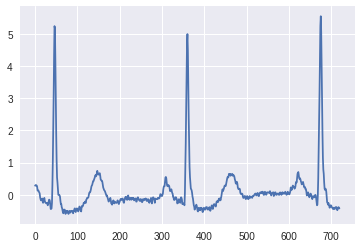

In [27]:
# P波 - QRS波 - T波が規則的に出現していることが確認できます．
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

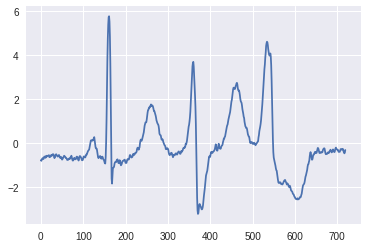

In [28]:
# 1 : 心室異所性拍動 (VEB)

idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])

In [0]:
# 8.5. 深層学習を用いた時系列データ解析

class ECGDataset(chainer.dataset.DatasetMixin):

    def __init__(
            self,
            path
    ):
        if os.path.isfile(os.path.join(path, 'X.npy')):
            self.X = np.load(os.path.join(path, 'X.npy'))
        else:
            raise FileNotFoundError("{}/X.npy not found.".format(path))
        if os.path.isfile(os.path.join(path, 'y.npy')):
            self.y = np.load(os.path.join(path, 'y.npy'))
        else:
            raise FileNotFoundError("{}/y.npy not found.".format(path))

    def __len__(self):
        return len(self.X)

    def get_example(self, i):
        return self.X[None, i].astype(np.float32), self.y[i]


In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer import Variable


class BaseBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            stride=1,
            dilate=1
    ):
        self.stride = stride
        super(BaseBlock, self).__init__()
        with self.init_scope():
            self.c1 = L.ConvolutionND(1, None, channels, 3, stride, dilate, dilate=dilate)
            self.c2 = L.ConvolutionND(1, None, channels, 3, 1, dilate, dilate=dilate)
            if stride > 1:
                self.cd = L.ConvolutionND(1, None, channels, 1, stride, 0)
            self.b1 = L.BatchNormalization(channels)
            self.b2 = L.BatchNormalization(channels)

    def __call__(self, x):
        h = F.relu(self.b1(self.c1(x)))
        if self.stride > 1:
            res = self.cd(x)
        else:
            res = x
        h = res + self.b2(self.c2(h))
        return F.relu(h)


class ResBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            n_block,
            dilate=1
    ):
        self.n_block = n_block
        super(ResBlock, self).__init__()
        with self.init_scope():
            self.b0 = BaseBlock(channels, 2, dilate)
            for i in range(1, n_block):
                bx = BaseBlock(channels, 1, dilate)
                setattr(self, 'b{}'.format(str(i)), bx)

    def __call__(self, x):
        h = self.b0(x)
        for i in range(1, self.n_block):
            h = getattr(self, 'b{}'.format(str(i)))(h)
        return h


class ResNet34(chainer.Chain):

    def __init__(self):
        super(ResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlock(64, 3)
            self.resblock1 = ResBlock(128, 4)
            self.resblock2 = ResBlock(256, 6)
            self.resblock3 = ResBlock(512, 3)
            self.fc = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = self.fc(h)
        return h


class Classifier(chainer.Chain):

    def __init__(
            self,
            predictor,
            lossfun=F.softmax_cross_entropy
    ):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            self.lossfun = lossfun

    def __call__(self, *args):
        assert len(args) >= 2
        x = args[:-1]
        t = args[-1]
        y = self.predictor(*x)

        # loss
        loss = self.lossfun(y, t)
        with chainer.no_backprop_mode():
            # other metrics
            accuracy = F.accuracy(y, t)
        # reporter
        reporter.report({'loss': loss}, self)
        reporter.report({'accuracy': accuracy}, self)

        return loss

    def predict(self, x):
        with chainer.function.no_backprop_mode(), chainer.using_config('train', False):
            x = Variable(self.xp.asarray(x, dtype=self.xp.float32))
            y = self.predictor(x)
            return y

In [0]:
# create_train_dataset()：学習用データセットを ECGDataset クラスに渡す
# create_trainer()：学習に必要な設定を行い，Trainerオブジェクトを作成

from chainer import optimizers
from chainer.optimizer import WeightDecay
from chainer.iterators import MultiprocessIterator
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.backends.cuda import get_device_from_id


def create_train_dataset(root_path):
    train_path = os.path.join(root_path, 'preprocessed', 'train')
    train_dataset = ECGDataset(train_path)

    return train_dataset


def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = ResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

In [0]:
train_dataset = create_train_dataset(dataset_root)

In [0]:

trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

In [34]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.1307      0.868304       
0           14          0.273237    0.923549       
0           21          0.0950281   0.96596        
0           28          0.058416    0.982701       
0           35          0.0658751   0.982143       
0           42          0.0506687   0.985491       
0           49          0.057125    0.986607       
0           56          0.063658    0.986607       
0           63          0.0600915   0.981027       
0           70          0.0391555   0.988281       
0           77          0.0325103   0.991629       
0           84          0.0344455   0.987723       
0           91          0.0281526   0.989955       
0           98          0.0266191   0.991629       
0           105         0.0318078   0.990513       
0           112         0.0304052   0.991071       
0           119         0.0293185   0.993304       
0           126         0.0290823   0.989397       
0           13

In [0]:
# 8.5.2. 評価
# create_test_dataset() : 評価用データの読み込み
# predict() : 推論を行い，結果の配列（正解ラベルと予測ラベル）を出力
# print_confusion_matrix() : 予測結果から混同行列とよばれる表を出力
# print_scores() : 予測結果から予測精度の評価指標を出力


from chainer import cuda
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def create_test_dataset(root_path):
    test_path = os.path.join(root_path, 'preprocessed', 'test')
    test_dataset = ECGDataset(test_path)
    return test_dataset


def predict(trainer, test_dataset, batchsize, device=-1):
    model = trainer.updater.get_optimizer('main').target
    ys = []
    ts = []
    for i in range(len(test_dataset) // batchsize + 1):
        if i == len(test_dataset) // batchsize:
            X, t = zip(*test_dataset[i*batchsize: len(test_dataset)])
        else:
            X, t = zip(*test_dataset[i*batchsize:(i+1)*batchsize])
        X = cuda.to_gpu(np.array(X), device)
        y = model.predict(X)
        y = cuda.to_cpu(y.data.argmax(axis=1))
        ys.append(y)
        ts.append(np.array(t))
    return np.concatenate(ts), np.concatenate(ys)


def print_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    target_names = ['Normal', 'VEB']
    cmx = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx, index=target_names, columns=target_names)
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cmx, annot=True, annot_kws={"size": 18}, fmt="d", cmap='Blues')
    plt.show()


def print_scores(y_true, y_pred):
    target_names = ['Normal', 'VEB']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("accuracy: ", accuracy_score(y_true, y_pred))


In [0]:
# 評価用データセットを用意
test_dataset = create_test_dataset(dataset_root)

In [37]:
# 評価用データに対して予測を行います
%time y_true_test, y_pred_test = predict(trainer, test_dataset, 256, 0)

CPU times: user 12 s, sys: 4.96 s, total: 17 s
Wall time: 17 s


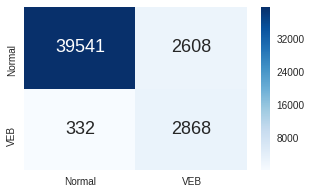

In [38]:
# 左上 : 実際に正常拍動であるサンプルが，正常拍動と予測された数
# 右上 : 実際に正常拍動であるサンプルが，VEBと予測された数
# 左下 : 実際にVEBであるサンプルが，正常と予測された数
# 右下 : 実際にVEBであるサンプルが，VEBと予測された数


print_confusion_matrix(y_true_test, y_pred_test)

In [39]:
# 適合率 (Precision) : それぞれの予測診断結果 (Normal or VEB) のうち，正しく診断できていた（正解も同じ診断結果であった）割合
# 再現率 (Recall) : それぞれの正解診断結果 (Normal or VEB) のうち，正しく予測できていた（予測も同じ診断結果であった）割合
# F1値 (F1-score) : 適合率と再現率の調和平均
# 正解率 (Accuracy) : 全ての診断結果 (Normal and VEB) のうち，正しく予測できていた（予測も同じ診断結果であった）割合

print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

      Normal       0.99      0.94      0.96     42149
         VEB       0.52      0.90      0.66      3200

   micro avg       0.94      0.94      0.94     45349
   macro avg       0.76      0.92      0.81     45349
weighted avg       0.96      0.94      0.94     45349

accuracy:  0.9351694634942336


In [0]:
# 8.6. 精度向上に向けて